In [47]:
%%capture
%run final_chars_classification.ipynb



In [48]:
%run table_detector.ipynb

In [49]:
%run final_functions.ipynb

In [50]:
%run preprocessing.ipynb

In [51]:
# initialize_models()
load_models()

REEEEEEEESSSSSSSSSSSSSS
[(291, 318, 1560, 318), (291, 578, 1560, 578), (291, 843, 1560, 843), (291, 1118, 1542, 1118), (291, 1383, 1560, 1383), (291, 1648, 1560, 1648), (380, 1909, 1560, 1909), (291, 2175, 1295, 2175), (291, 2448, 1560, 2448), (296, 2725, 1555, 2725)]


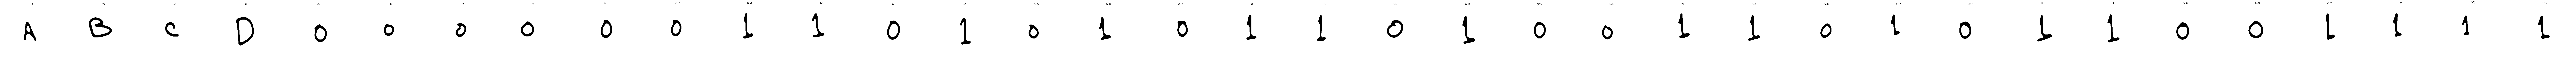

36

In [52]:
# img = cv2.imread("./table extraction/table_images/table6.jpeg")
img = cv2.imread("./test_images/table7.jpg")

cells, col_num, rown_num = cells_extraction(img, table= True)

# cells = cells[ 0:-4]



show_images(cells)
len(cells)



img shape: (235, 294), max=255, min=0,median=255.0 and type uint8
tolerance: 14.700000000000001


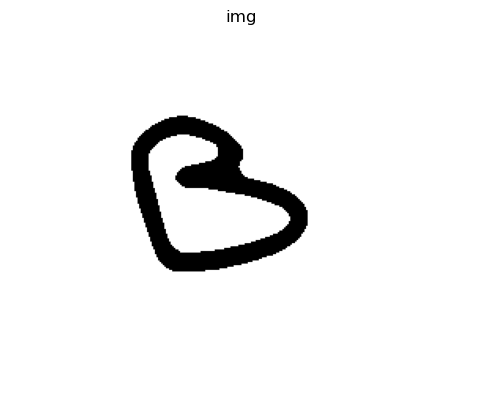

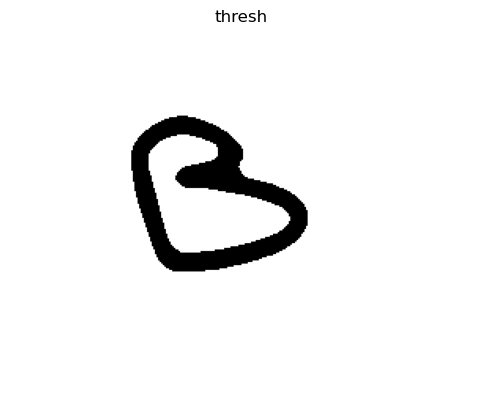

contours before area filtering
-3383.5, 7702.5, -68562.0, 
contours after area filtering
7702.5, 
masks


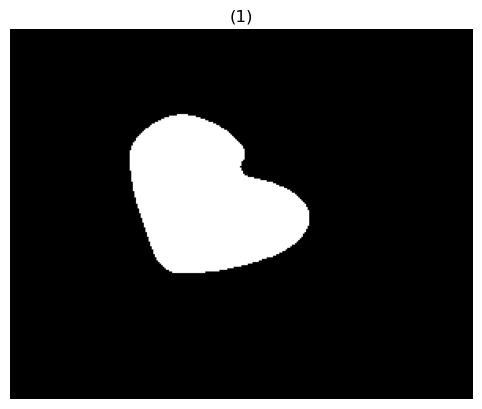

contours after merging


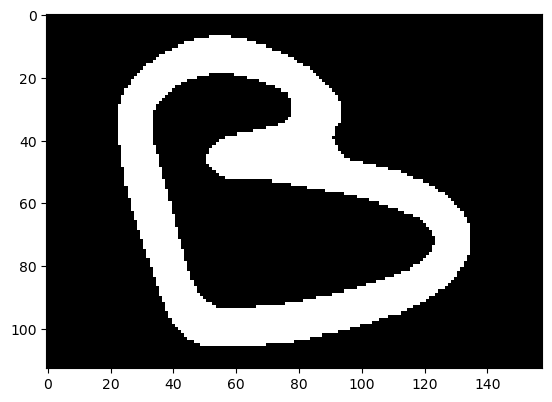

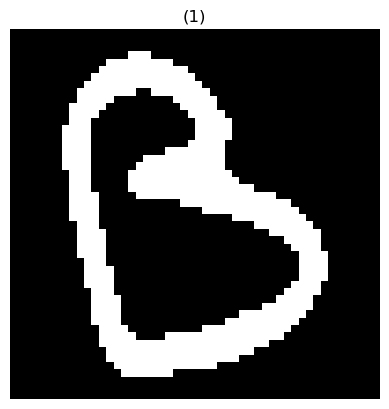

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)]

In [53]:
get_letters(cells[1], True)


In [54]:
# print(classify(cells[1], is_expression=True))

In [55]:
# letters = [classify(i, is_letter=True) for i in cells[0:col_num]]
# for r in letters:
#     print(r)


In [56]:
# print(cells)
# cells = np.array(cells)

# # cells = get_letters

# # show_images(get_letters(cells[], True))
# results = [classify(i, is_0_1=True) for i in cells[col_num:]]
# for r in results:
#     print(r)


In [61]:
def solve(img, is_table = False):
    
    img = cv2.resize(img, (2448, 3264)) # size of A4
    img = img.astype(np.uint8)
    img = preprocessing(img, True)
    
    # show_images([img])

    if(is_table):
        cells, col_num, row_num = box_extraction(img, showTrace= False)#, table= True)
        print(row_num)
        print(col_num)
        #### letters 
        letters = [classify(i, is_letter=True) for i in cells[0:col_num]]
        numbers = [classify(i, is_0_1=True) for i in cells[col_num:]]
        
        numbers = np.array(numbers)
        # .reshape(row_num-1, -1)
        return letters, numbers
    else: 

        expression = classify(img, is_expression=True)
        print(expression)
        return get_table(expression)
        # return expression

    

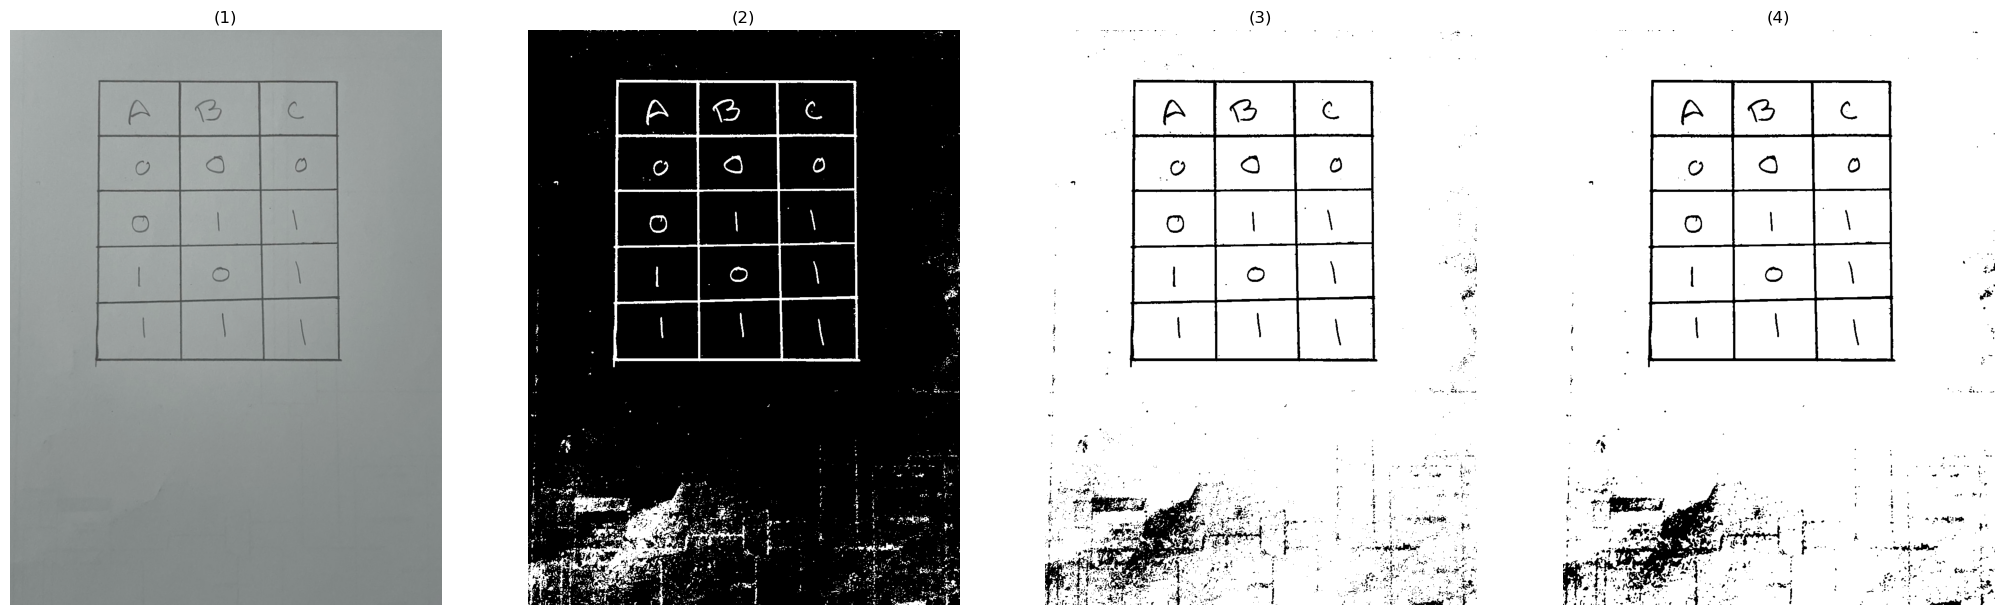

REEEEEEEESSSSSSSSSSSSSS
[(1171, 304, 1393, 304), (497, 611, 1394, 611), (494, 921, 856, 921), (493, 1236, 728, 1236), (663, 1543, 1094, 1543), (1622, 1882, 1831, 1882)]
5
3


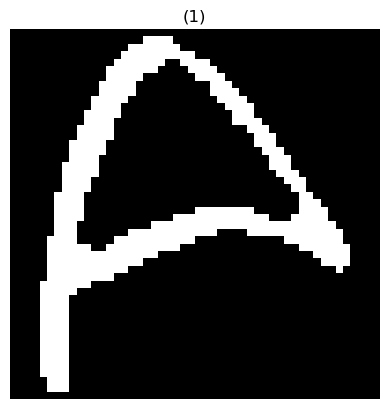

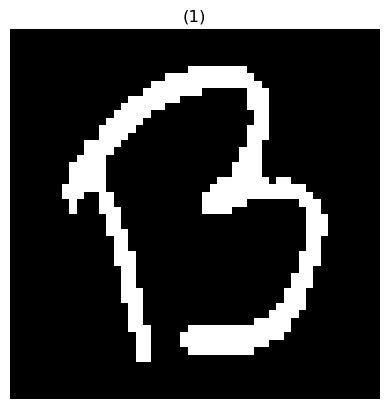

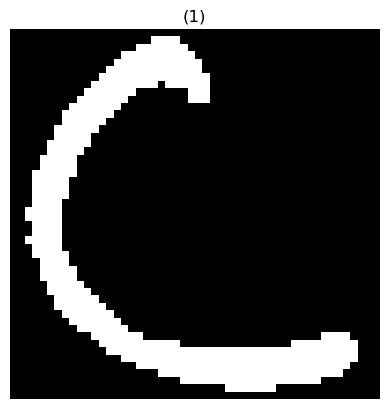

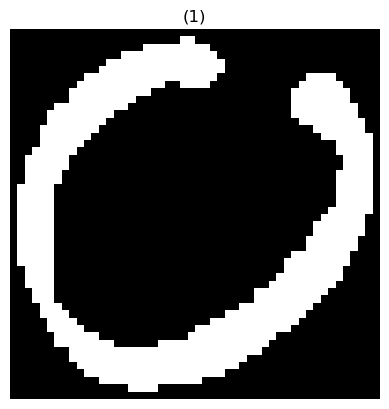

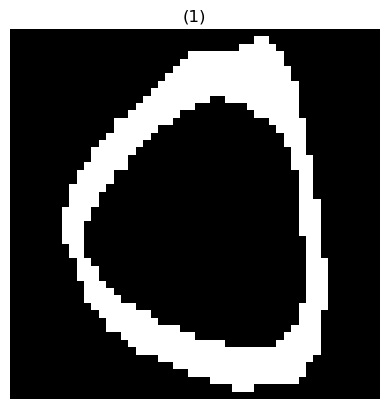

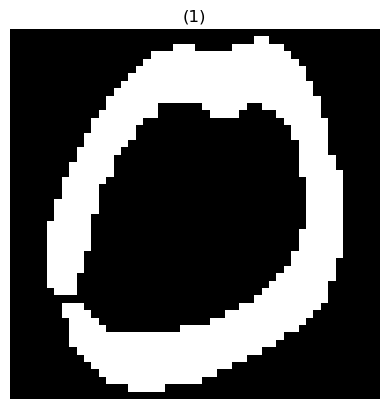

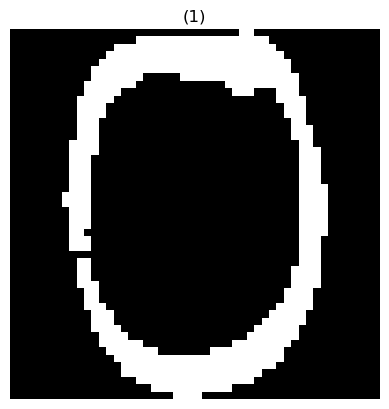

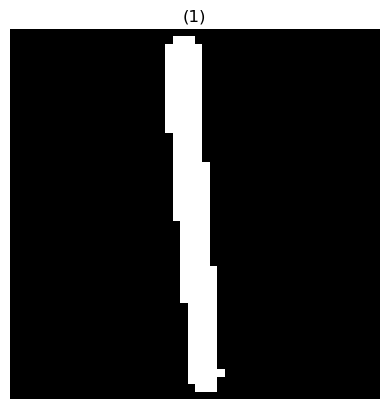

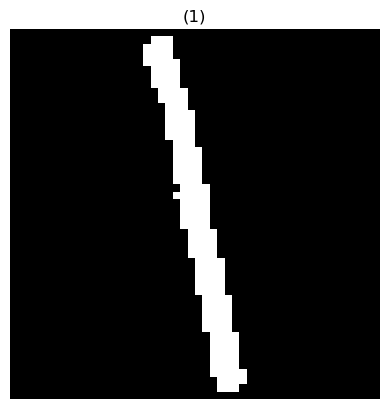

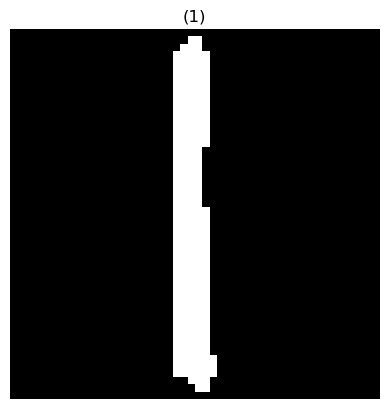

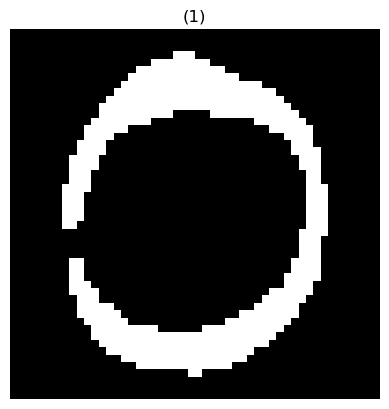

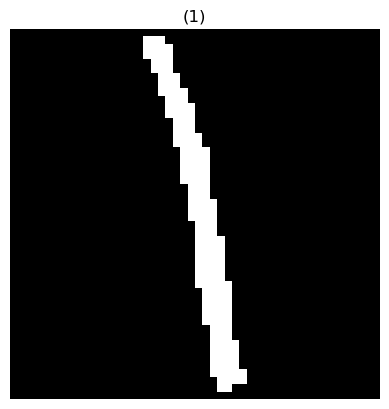

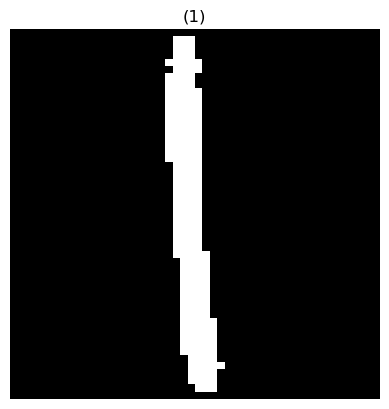

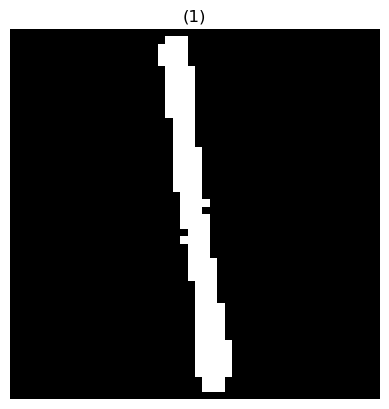

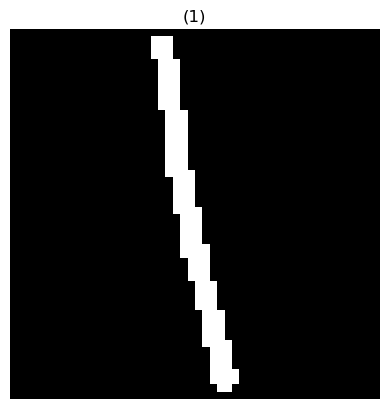

(4, 3)

In [62]:
img = cv2.imread("./test_images/table3.jpg")

# print(solve(img))

letters, numbers = solve(img, is_table=True)
numbers.shape



In [64]:
print(letters)
print(numbers)

[array(['A'], dtype='<U1'), array(['B'], dtype='<U1'), array(['C'], dtype='<U1')]
[['0' '0' '0']
 ['0' '1' '1']
 ['1' '0' '1']
 ['1' '1' '1']]
